In [106]:
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pylab as plt
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import statsmodels.api as sm
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot

# Téma 5: Operátor $B$, ARIMA(p,d,q)

# Operátor zpoždění

Operátor zpoždění ([lag operator, backshift operator](https://en.wikipedia.org/wiki/Lag_operator)) značíme $B$ nebo $L$ a používáme pro zjednodušení zápisu:

$$
\begin{aligned}
BX_t &= X_{t-1} \\
B^{-1}X_t &= X_{t+1} \\
B^k X_t &= \underbrace{B\cdot B \cdots B}_{k\times}X_t = X_{t-k}.
\end{aligned}
$$

Díky tomu můžeme zavádět **AR(p)** proces takto:

$$
\begin{aligned}
X_t &= \sum_{i=1}^p \phi_i X_{t-i} + \varepsilon_t \\
&\Longrightarrow \qquad 
\varepsilon_t = X_t - \phi_1 B^1 X_{t} - \ldots - \phi_p B^p X_{t}
= \left( 1 - \sum_{i=1}^p \phi_i B^i\right) X_t.
\end{aligned}
$$

Analogicky pro **MA(q)** máme

$$
X_t = \left( 1 + \sum_{i=1}^q \theta_i B^i \right) \varepsilon_t,
$$

z čehož pro **ARMA(p,q)** bez konstanty $c$ plyne

$$
\Phi X_t = \Theta \varepsilon_t, \qquad\text{kde}\qquad
\Phi=1-\sum_{i=1}^p \phi_i B^i \qquad\text{a}\qquad
\Theta = 1+\sum_{i=1}^q \theta_i B^i.
$$

### Operátor diference $\nabla$

$$
\begin{aligned}
\nabla X_t &= X_t - X_{t-1} = (1-B) X_t, \\
\nabla^2 X_t &= \nabla(\nabla X_t) = \nabla X_t - \nabla X_{t-1} = (1-B) \nabla X_t \\
&= (1-B)^2 X_t,\\
\nabla^k X_t &= (1-B)^k X_t.
\end{aligned}
$$

Díky všem uvedeným operátorům můžeme definovat **ARIMA(p,d,q)** model následovně:

$$
{\Phi}(1-B)^d X_t = \Theta \varepsilon_t, \qquad\text{kde}\qquad
\Phi=1-\sum_{i=1}^p \phi_i B^i \qquad\text{a}\qquad
\Theta = 1+\sum_{i=1}^q \theta_i B^i,
$$

popřípadě s konstantou $c$

$$
\Phi (1-B)^d X_t = c + \Theta \varepsilon_t.
$$

**Zkuste si zapsat např. ARIMA(1,1,1), ujasní se vám to :-)**

### K čemu jsou operátory dobré?

- umožňují snadný zápis charakteristických polynomů při vyšetřování stacionarity AR a invertibility MA procesu.
- jde s nimi dělat různá algebraická kouzla díky komutativitě $B(\beta X_t) = \beta BX_t$, distributivitě atd.

Ještě než skočíme do dalšího tématu, podívejme se na záludnosti ARMA modelů. Simulujme časovou řadu pomocí [arma_generate_sample](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.arma_generate_sample.html?highlight=generate#statsmodels.tsa.arima_process.arma_generate_sample) ze statsmodels:

{'bic':              0            1            2
 0  1882.579307  1538.212012  1446.827079
 1  1559.903248  1457.081346  1447.768430
 2  1455.875146  1449.207715  1453.256041
 3  1449.148348  1454.735849  1459.470567,
 'bic_min_order': (0, 2)}

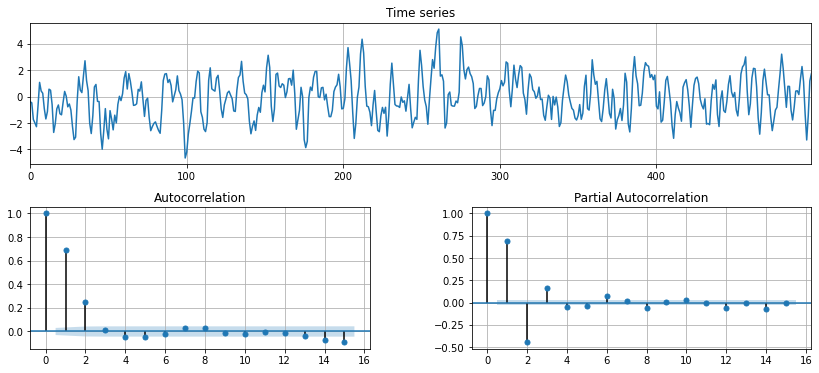

In [118]:
ar_params = [.27]      ### koeficienty AR, bez offsetu
ma_params = [.8, .3]   ### koeficienty MA, bez offsetu
ar = np.r_[1, -np.array(ar_params)]
ma = np.r_[1, np.array(ma_params)]
y = sm.tsa.arma_generate_sample(ar, ma, 500)
tsplot(y)
sm.tsa.arma_order_select_ic(y, ic='bic', max_ar=3, max_ma=2)

# Modely ARIMA(p,d,q)

Nyní se podíváme blíže na modely ARIMA (AutoRegressive Integrated Moving Average). Zde máme hned tři parametry:

- p - řád autoregresní části (AR)
- q - řád modelu klouzavých průměrů (MA)
- d - řád differencování

Diferencováním řady se snažíme odstranit z ní trend nebo náhodnou procházku. To lze nejlépe vidět na příkladu náhodné procházky, která vlastně vzniká integrováním náhodně generovaných kroků z množiny {-1, 1} (potenciálně jiných, ale to neřešme, jen přidejme trochu normálního šumu). Zkusme $d\in\{0,1,2\}$, co uvidíme v grafu zde a níže.

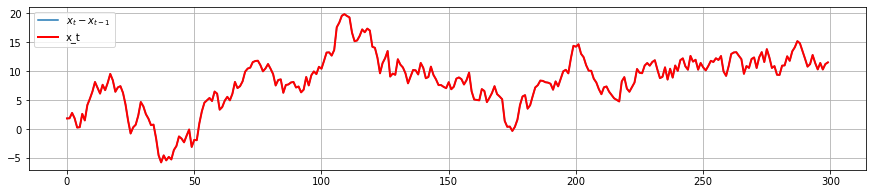

In [57]:
ndat = 300
i = 1                ### řád integrování: 1 = procházka, 2 = :)
d = 0                ### řád diferencování
np.random.seed(123)  # pro stejná data při různých nastaveních
x_tmp = np.random.randint(-1, 2, size=ndat) + np.random.normal(size=ndat)
x = np.cumsum(x_tmp)
model = sm.tsa.ARIMA(x, order=(0,d,0))   # Deprecated, ale sm.tsa.arima.ARIMA nevrací diferenc. řadu
plt.figure(figsize=(15,3))
plt.plot(np.arange(d,ndat), model.endog, label=r'$x_t - x_{t-1}$')
plt.plot(x, 'r', lw=2, label='x_t')
plt.legend()
plt.show()

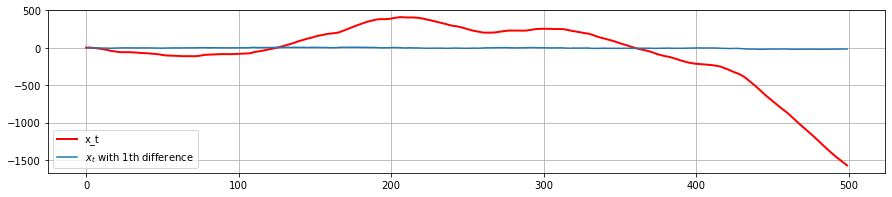

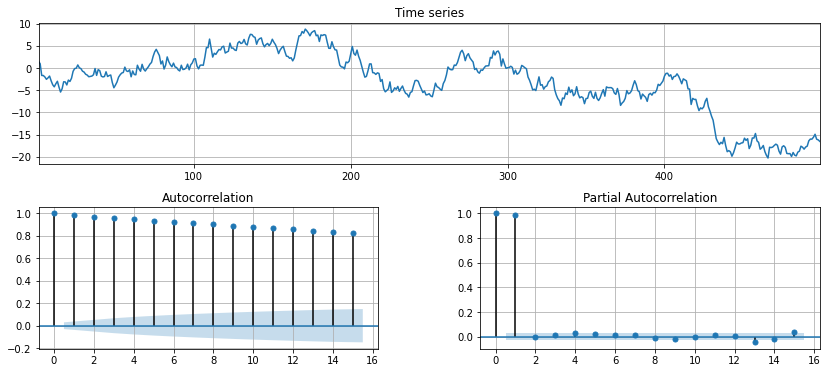

In [105]:
ndat = 500
i = 2                ### řád integrování: 1 = procházka, 2 = :)
d = 1                ### řád diferencování - d=i -> bílý šum

np.random.seed(11)
x = np.random.normal(size=ndat)
for _ in range(i):
    x = np.cumsum(x)
df = pd.DataFrame({'x': x})
df_diff = df.copy()
for _ in range(d):
    df_diff['x'] = df_diff['x'].diff()
plt.figure(figsize=(15,3))
plt.plot(df['x'], 'r', lw=2, label='x_t')
plt.plot(df_diff['x'], label=rf'$x_t$ with {d}th difference')
plt.legend()
plt.show()
tsplot(df_diff['x'].dropna())
plt.show()

Zkusme se podívat na syrová data `x` a na diferencovaná v `model.endog`.

> **Zjištění:**
> - **Časové řady s trendem nebo náhodnou procházkou jsou vždy silně pozitivně autokorelované. V ACF vidíme veliké korelace, v PACF typicky v 1. lagu a blízkou 1.**
> - **Časové řady s ACF v 1. lagu s hodnotami -0.5 a méně mohou být přediferencované.**
> - **Modely s d=1 typicky předpokládají konstantní průměrný trend (náhodná procházka s driftem)..**

To, co vypadá jako význačná charakteristika pro AR proces je ve skutečnosti znamení poddiferencovanosti - diferencováním ji odstraníme a v uvedeném příkladu se dostaneme k ryze náhodnému procesu - procházce. Přediferencováním dostaneme opak - MA charakteristiku. Z toho plyne následující: **AR charakteristika může značit poddiferencovanost časové řady, zatímco MA charakteristika přediferencovanost.** Jedno z užitečných pravidel je, že $d\leq 2$, přičemž druhé diference jsou v praxi relativně řídké. **A při $d=2$ nepoužíváme v ARIMA modelu konstantu $c$.** Výjimky jsou řídké.

> **Role konstanty v ARIMA modelu:**
> - při $d=0$ konstanta zavádí nenulovou střední hodnotu a vyplatí se ji zkusit.
> - při $d=1$ konstanta zavádí nenulový "průměrný" trend a může se vyplatit.
> - při $d=2$ by konstanta měla význam "trendu v trendu", což obvykle nechceme.

## Běžné ARIMA modely

- ARIMA(0,0,0)+c - konstantní model
- ARIMA(0,1,0) - model náhodné procházky (viz výše)
- ARIMA(0,1,0)+c - náhodná procházka s driftem
- ARIMA(1,0,0)+c - AR(1) model
- ARIMA(2,0,0)+c - AR(2) model
- ARIMA(1,1,0)+c - AR(1) model na jednou diferencovaných datech
- ARIMA(2,1,0)+c - AR(2) model na jednou diferencovaných datech
- ARIMA(0,1,1) - jednoduché exponenciální vyhlazování - MA(1) model na diferencovaných datech
- ARIMA(0,1,1)+c - jednoduché exponenciální vyhlazování - MA(1) na diferencovaných datech - s konst. lin. trendem
- ARIMA(1,1,2) - lineární exponenciální vyhlazování s tlumeným trendem
- ARIMA(0,2,2) - zobecněné lineární exponenciální vyhlazování

Zkuste sami identifikovat chování ARIMA(1,0,0)+c kde $c$ je drift (to je nápověda):

1. $\phi_1 = 0$
2. $\phi_1 = 1, c=0$
3. $\phi_1 = 1, c \ne 0$
4. $\phi_1 < 0$

(odpovědi: bílý šum, náhodná procházka, náhodná procházka s driftem, řada oscilující mezi kladnými a zápornými hodnotami).

## Obecná pravidla (se spoustou výjimek :))

- $d \leq 2$ - spíše zřídka potřebujeme druhé diference a třetí už jsou vyloženě výjimečné. 
- $d = 2 \Rightarrow$ nepoužíváme skoro nikdy konstantu $c$ v modelu.
- zpravidla volíme $p=0$ nebo $q=0$. Směsové modely jsou spíše v menšině, ale ve fyzikálních systémech jsou často ARIMA(p,0,p-1).
- $p+q \leq 3$ - složitější modely jsou řídké.
- koeficienty $\phi_i$ blízké $\theta_i$ mohou pracovat proti sobě.
- obecně volíme co nejjednodušší modely.
- modely můžeme porovnat kritérii AIC, BIC.

![arima](img/ARIMA.png)

**ALE:**
- mohou se vyskytnout (a vyskytují) složitější modely porušující výše uvedená pravidla.
- i tak ale $p, q$ by měly být relativně malé (**R**: `auto.arima()` končí u (5,5) z dobrého důvodu)
- **StatsModels**: `tsa.arma_order_select_ic()`
- velkým problémem složitých modelů je totiž **redundance parametrů**.

## Redundance parametrů

AR a MA části modelu pracují i proti sobě - zvýšíme-li řády u obou, mohou se navzájem vyrušit. To je **neužitečné**, neboť roste složitost modelu. Uveďme si jednoduchý příklad. Uvažujme jednoduchý model ARMA(1,2) ve tvaru

$$
X_t = \phi X_{t-1} + \varepsilon_t + \theta_1\varepsilon_{t-1} + \theta_2\varepsilon_{t-2}.
$$

Zřejmě platí, že minulá hodnota

$$
X_{t-1} = \phi X_{t-2} + \varepsilon_{t-1} + \theta_1\varepsilon_{t-2} + \theta_2\varepsilon_{t-3}.
$$

Vynásobme výraz pro $X_{t-1}$ libovolnou nenulovou konstantou $c$,

$$
cX_{t-1} = c\phi X_{t-2} + c\varepsilon_{t-1} + c\theta_1\varepsilon_{t-2} + c\theta_2\varepsilon_{t-3}
$$

a odečtěme od původního výrazu pro $X_t$ nahoře. Po úpravě dostaneme

$$
X_t = (\phi+c) X_{t-1} -c\phi X_{t-2} + \varepsilon_t + (\theta_1-c)\varepsilon_{t-1} + (\theta_2 -c\theta_1)\varepsilon_{t-2} - c\theta_2\varepsilon{t-3},
$$

což je ARMA(2,3)! A zjevně nejsou parametry jednoznačně určené, neboť $c$ je libovolné. V "backshift" notaci uvedené níže to znamená, že je-li $\phi B X_t = \theta B \varepsilon_t$ odpovídající model procesu, potom je jím i $(1-cB)\phi B X_t = (1-cB) \theta B \varepsilon_t$ pro libovolnou konstantu $c$. Jednoznačnou parametrizaci dostaneme pokrácením všech společných faktorů v AR a MA charakteristických rovnicích - to už jsme ale za hranicí MI-SCR.

### Příklad redundance

Uvažujme bílý šum pro všechna $t$, tj. pro dva konsekutivní libovolné časové okamžiky

$$
\begin{aligned}
X_t &= \varepsilon_t \\
X_{t-1} &= \varepsilon_{t-1}.
\end{aligned}
$$

Vynásobme druhou rovnici např. 0.5 a převeďme vše na jednu stranu

$$
0 = -0.5 X_{t-1} + 0.5 \varepsilon_{t-1}
$$

a jelikož jde o nulu (aspoň ve střední hodnotě), sečtěme to s první rovnicí:

$$
X_t = -0.5 X_{t-1} + \varepsilon_t + 0.5 \varepsilon_{t-1}.
$$

Vidíme, že bílý šum je ekvivalentní k nějakému ARMA(1,1). Přesto, pokud bychom se podívali na ACF a PACF, nic by nenasvědčovalo tomu, že by mělo jít o takto složitější model. Pokud bychom si vynutili fitování ARMA(1,1), potom budou odhady koeficientů symetrické a budou pusobit proti sobě (viz ono $c$ v teorii výše). Toto je jeden z důvodů, proč tolik preferujeme jednodušší modely a proč je vždy rozumné zkoumat grafy ACF a PACF. Podívejme se na příklad:

In [119]:
# sm.tsa.arima.ARIMA je preferovaná cesta, sm.tsa.arima_model je deprecated do 0.12.
x = norm.rvs(size=100000)
tsplot(x)
plt.clf()
model = sm.tsa.arima.ARIMA(x, order=(1,0,1), trend='n').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               100000
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -141799.056
Date:                Sun, 11 Oct 2020   AIC                         283604.111
Time:                        20:46:39   BIC                         283632.650
Sample:                             0   HQIC                        283612.772
                             - 100000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0064      4.035      0.002      0.999      -7.901       7.914
ma.L1         -0.0056      4.035     -0.001      0.999      -7.913       7.902
sigma2         0.9981      0.004    224.260      0.0

<Figure size 1008x432 with 0 Axes>

In [120]:
model.conf_int()

array([[-7.9012958 ,  7.91405881],
       [-7.91332524,  7.90213827],
       [ 0.98938421,  1.00683053]])

# Testy a analýzy

(...aneb malé opáčko frekventistické statistiky)

Připomeňme si letem světem základní princip testování hypotéz. Zavádíme:
- **nulovou hypotézu** $H_0$ - základní hypotéza, její platnost chceme v ideálním případě zamítnout (*reject*).
- **alternativní hypotézu** $H_1$ či $H_A$ - zamítáme-li $H_0$, pak ve prospěch této hypotézy.

V případě analýzy časových řad jsou testy zpravidla **oboustranné**, kde $H_0$ říká, že hodnota testovaného parametru je rovna nějakému číslu, proti $H_1$ která předpokládá nerovnost. Připomeňme, že jednostranné testy by tvrdily, že hodnota parametru je buď větší (pravostranný test), nebo menší (test levostranný).

Jsou dva možné výsledky statistického testu:
- **zamítáme $H_0$** (ve prospěch hyp. alternativní) - tj. máme dostatek statistických důkazů (evidence) v její neprospěch. Anglicky: *reject H_0*.
- **nezamítáme $H_0$** - nemáme dostatek statistických důkazů proti její platnosti. Tím ale $H_0$ nepotvrzujeme!!! Anglicky: *fail to reject $H_0$*.

Testování provádíme na hladině testu (též významnosti) $\alpha\in[0,1]$, zpravidla 0.05 či nižší. Tato hladina nám říká, jaká je pravděpodobnost, že $H_0$ bude neoprávněně zamítnuta.

Testování je založeno na testové statistice s obvykle nějakým známým vhodným rozdělením (typicky Studentovým $t$ apod.). Za platnosti $H_0$ nabývá tato veličina hodnost z nějakého oboru (vzpomeňte intervaly spolehlivosti) s pravděpodobností $1-\alpha$ a s pravděpodobností $1-\alpha$ potom z oboru kritického. Pokud hodnota statistiky leží v kritickém oboru, $H_0$ zamítáme.

Software zpravidla počítá **p-hodnotu**, tj. pravděpodobnost, že by testovací statistika dosáhla své hodnoty či hodnot ještě více svědčících proti $H_0$ při platnosti $H_0$. Z wikipedie:

> p-value is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct.

### Ljungův-Boxův Q test
Test ověřuje nekorelovanost časové řady, v případě výsledku fitování jde o nekorelovanost standardizovaných reziduí (chyb predikce):

$$
\begin{aligned}
H_0&: \text{data jsou nekorelovaná}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

Testová statistika pro $n$ dat, zpoždění $k$ a výběrový autokorelační koeficient $r_k$ má na horizontu testování $h$ podobu

$$
Q = n(n+2) \sum_{k=1}^h \frac{r_k^2}{n-k} \sim \chi_{h}^2.
$$

Při testování nekorelovanosti reziduí z modelu ARIMA(p, 0, q) je počet stupňů volnosti $h-p-q$. Jednodušší variantou je Boxův-Pierceův test, který `statsmodels` rovněž umí.

### Test heteroskedasticity

Test ověřuje, zda je jsou standardizovaná rezidua (chyby regrese) heteroskedastická, tj. mají proměnnou varianci:

$$
\begin{aligned}
H_0&: \text{rezidua nejsou heteroskedastická}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

V implementaci se rozdělí data na tři třetiny a testuje se, zda je součet kvadrátů reziduí v dřívější třetině větší než součet kvadrátů reziduí v pozdější třetině. Označme $h=\lfloor n/3 \rfloor$ kde $n$ je počet dat, $d$ počet zahozených počátečních (burn-in) reziduí a rezidua $\tilde\varepsilon_t$;   testovací statistika má podobu

$$
H(h) = \frac{\sum_{t=n-h+1}^n \tilde\varepsilon_t^2}{\sum_{t=d+1}^{d+1+h} \tilde\varepsilon_t^2} \sim F_{h,h}.
$$

Jde tedy o [Fisherův $F$-test](https://en.wikipedia.org/wiki/F-test_of_equality_of_variances).

### Jarque-Bera test

Test ověřuje složenou hypotézu, že data mají výběrovou [šikmost](https://en.wikipedia.org/wiki/Skewness) $g_1=0$ a výběrovou [špičatost](https://en.wikipedia.org/wiki/Kurtosis) $g_2=3$, stejně jako normální rozdělení:

$$
\begin{aligned}
H_0&: \text{rezidua mají $g_1=0, g2=3$}, \\
H_1&: \text{neplatí $H_0$}.
\end{aligned}
$$

Testová statistika je asymptoticky $\chi^2$ rozdělená, pro $n$ dat má podobu

$$
JB = \frac{n}{6}\left(g_1^2 + \frac{(g_2 - 3)^2}{4}\right) \sim \chi_2^2.
$$

Pro malé rozsahy výběru se nutné využívat lepší aproximace, neboť $\chi^2$ aproximace není dostatečná. V implementaci se podobně jako u předešlého testu vynechává určitý počet počátečních dat (reziduí).